In [2]:
import os 
os.chdir('../')
import argparse
from hydra import compose, initialize
import sys
sys.path.append('.')
from meg_ssl.dataclass import parse_dataset
from meg_ssl.models import get_model_and_trainer
from meg_ssl.utils import set_seed
from omegaconf import OmegaConf
import wandb
import numpy as np

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
class Args():
    config='sbj1_6k'
    meg_model='scmbm'
    vision_model='vit_clip16'
    decode_model='mlp' 
    preprocess='fs1000_dura200'
    device_counts=1 
    exp='scmbm_4-fs1000-dura200'
    h5name='vc-fs1000-dura200-1'
    seed = 42
    resume=None

args = Args()
set_seed(args.seed)
with initialize(config_path='../meg_ssl/task_configs/'):
    cfg = compose(args.config)
with initialize(config_path='../meg_ssl/ssl_configs/model'):
    cfg.meg_encoder = compose(args.meg_model)
print('INFO ========= model config is overrided by ', args.meg_model)
with initialize(config_path='../meg_ssl/ssl_configs/preprocess'):
    cfg.preprocess = compose(args.preprocess)
print('INFO ========= preprocess config is overrided by', args.preprocess)
with initialize(config_path='../meg_ssl/task_configs/model'):
    cfg.image_encoder = compose(args.vision_model)
print('INFO ========= image_encoder config is overrided by', args.vision_model)
with initialize(config_path='../meg_ssl/task_configs/model'):
    cfg.decoder = compose(args.decode_model)
print('INFO ========= decoder config is overrided by', args.decode_model)

# num_electrodes, fs, bpがh5ファイルに関係している
if args.h5name is None:
    cfg.h5_root = cfg.h5_root.format(h5_name='fs{}-bp{}_{}'.format(cfg.preprocess.brain_resample_rate, *cfg.preprocess.bandpass_filter))
else:
    cfg.h5_root = cfg.h5_root.format(h5_name=args.h5name)
if args.exp is None:
    args.exp = args.config
cfg.training.logdir = cfg.training.logdir.format(exp_name=args.exp)
cfg.training.ckpt_dir = cfg.training.ckpt_dir.format(exp_name=args.exp)

cfg.resume_path = args.resume
cfg.meg_encoder_path = cfg.meg_encoder_path.format(exp_name=args.exp)

# decoderのinput features は前段のモデルのパラメタに依存する & output featuresはimage encoderの埋め込み次元に依存する
if cfg.decoder.name == 'mlp':
    if cfg.training.global_pool:
        cfg.decoder.parameters.input_features = cfg.meg_encoder.parameters.embed_dim
    else:
        cfg.decoder.parameters.input_features = int(cfg.preprocess.meg_duration * cfg.preprocess.brain_resample_rate / cfg.meg_encoder.parameters.patch_size * cfg.meg_encoder.parameters.embed_dim) # time_len * resample_rate / patch_size * num_dim
    cfg.decoder.parameters.output_features =  512 # image_encoder.vision_embed_dim




/tmp/ipykernel_19572/1767207450.py:15: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/task_configs/'):
/tmp/ipykernel_19572/1767207450.py:17: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/ssl_configs/model'):


INFO ========= model config is overrided by  scmbm
INFO ========= preprocess config is overrided by fs1000_dura200


/tmp/ipykernel_19572/1767207450.py:20: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/ssl_configs/preprocess'):
/tmp/ipykernel_19572/1767207450.py:23: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/task_configs/model'):


INFO ========= image_encoder config is overrided by vit_clip16


/tmp/ipykernel_19572/1767207450.py:26: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/task_configs/model'):


INFO ========= decoder config is overrided by mlp


In [12]:
# get dataset
def get_dataset(cfg:OmegaConf):
    dataset_names:dict = cfg.dataset_name
    # import pdb; pdb.set_trace()
    dataset_yamls:dict = cfg.dataset_yaml
    num_trial_limit:dict = cfg.total_limit
    preproc_config:OmegaConf = cfg.preprocess
    h5_root:str = cfg.h5_root
    image_preprocs:list = []
    meg_preprocs:list = []
    only_meg:bool = True
    on_memory:bool = False
    dataset_dict:dict = parse_dataset(dataset_names, dataset_yamls, preproc_config, num_trial_limit, 
                                      h5_root, image_preprocs, meg_preprocs, only_meg, on_memory)
    
    return dataset_dict['train'], dataset_dict['val']
    

# get model
def get_model(config, usewandb, devuce_count):
    model, trainer = get_model_and_trainer(config, device_count=devuce_count, usewandb=usewandb, only_model=False)
    return model, trainer



# run
def run(cfg:OmegaConf, wandb_key_path:str, device_counts:int):
    
    cfg.model.parameters.time_len = int(np.floor(cfg.preprocess.meg_duration * cfg.preprocess.brain_resample_rate))
    print('============================ settings ==============================')
    print(OmegaConf.to_yaml(cfg))
    print('=============================== END ================================')
    # dataset
    train_dataset, val_dataset = get_dataset(cfg)
    cfg.model.parameters.in_chans = train_dataset.datasets[0].num_electrodes
    print('num_electrodes: ', cfg.model.parameters.in_chans)
    print('num trials: Train: {}, Val: {}'.format(len(train_dataset), len(val_dataset)))
    # model
    model, trainer = get_model_and_trainer(cfg, device_count=device_counts, usewandb=False, only_model=False) # get_model(cfg, usewandb, device_counts)
    
    

In [20]:
train_dataset, val_dataset = get_dataset(cfg)

cfg.meg_encoder.parameters.time_len = int(np.floor(cfg.preprocess.meg_duration * cfg.preprocess.brain_resample_rate))
cfg.meg_encoder.parameters.in_chans = train_dataset.datasets[0].num_electrodes

model,_ = get_model_and_trainer(cfg, device_count=args.device_counts, usewandb=False, only_model=True)


=================GOD=================
sbj_1-train-session_1_2_3_4_5_7_8_9_10_11
dataset_info_list:  [{'image_root': '/storage/dataset/ECoG/internal/GODv2-4/images_trn', 'meg_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_block001', 'meg_label_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/labels/ses_1', 'meg_trigger_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/trigger/ses01', 'meg_rest_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_block001', 'sbj_name': 'sbj01', 'h5_file_name': '../../../dataset/ssl_dataset/vc-fs1000-dura200-1/GOD/sbj01_data_block001.h5', 'image_id_path': '/work/project/MEG_GOD/GOD_dataset/clip_image_training.mat'}, {'image_root': '/storage/dataset/ECoG/internal/GODv2-4/images_trn', 'meg_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_block002', 'meg_label_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/labels/ses_2', 'meg_trigger_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/trigger/ses02', 'meg_rest_path': '/work/project/MEG_GOD/GO

ROI:  ['occipital/left', 'occipital/right']
channel (-1 is done because matlab starts from 1):  [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
num channels:  22
load h5 file ../../../dataset/ssl_dataset/vc-fs1000-dura200-1/GOD/sbj01_data_block010.h5
ROI:  ['occipital/left', 'occipital/right']
channel (-1 is done because matlab starts from 1):  [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
num channels:  22
load h5 file ../../../dataset/ssl_dataset/vc-fs1000-dura200-1/GOD/sbj01_data_block011.h5
=================GOD=================
sbj_1-train-session_6_12
dataset_info_list:  [{'image_root': '/storage/dataset/ECoG/internal/GODv2-4/images_trn', 'meg_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_block006', 'meg_label_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/labels/ses_6', 'meg_trigger_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/trigger/ses0

In [22]:
import torch
model.load_state_dict(torch.load(cfg.meg_encoder_path))
model.eval().cuda()

<All keys matched successfully>

In [41]:
idx = 0
eeg = val_dataset[idx]
eeg_tensor = torch.from_numpy(eeg).unsqueeze(0).cuda()
with torch.no_grad():    
    loss, pred_eeg, mask = model(eeg_tensor)# .cpu().numpy()
    pred_eeg = model.unpatchify(pred_eeg).to('cpu').squeeze(0).numpy()
pred_eeg = pred_eeg.squeeze()

patch_size = model.patch_size
mask = mask.to('cpu').squeeze(0).numpy()
mask_start = np.where(mask)[0] * patch_size
mask_end = np.where(mask)[0] * patch_size + patch_size

In [39]:
import matplotlib.pyplot as plt

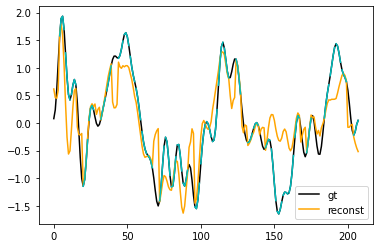

In [57]:
x_axis = np.arange(0, eeg.shape[-1])
elec = 0
plt.plot(eeg[elec,:], 'k-',label='gt')
plt.plot(pred_eeg[elec,:], color='orange',label='reconst')

for s, e in zip(mask_start, mask_end):
    plt.plot(x_axis[s:e], eeg[elec, s:e], 'c-')
plt.legend()
plt.show()

In [33]:
pred_eeg.shape

(1, 52, 88)

In [42]:
mask

array([0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
       1.], dtype=float32)